In [1]:
!pip install yfinance arch

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from tqdm import tqdm
from datetime import datetime, timedelta
import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.9 MB/s eta 0:00:00


In [2]:
warnings.filterwarnings('ignore')
register_matplotlib_converters()

In [5]:
# 1) Define ticker symbols and date ranges
tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW']
start_date = '2010-01-01'
end_date = '2025-04-30'
train_end = '2024-12-31'
test_start = '2025-01-01'

# 2) Download adjusted close data
data = yf.download(tickers, start=start_date, end=end_date)
close_data = data['Close'].copy()

# 3) Compute log prices
log_close_data = np.log(close_data)

# 4) Combine into a MultiIndex DataFrame
log_data = pd.concat([close_data, log_close_data], axis=1, keys=['Close', 'LogClose'])
print("Combined head:\n", log_data.head(), "\n")


[*********************100%***********************]  20 of 20 completed

Combined head:
                Close                                                      \
Ticker          AAPL     AIR.PA     ALV.DE    AMZN    ASML.AS      BRK-B   
Date                                                                       
2010-01-04  6.431897  11.426847  43.213928  6.6950  27.861845  66.220001   
2010-01-05  6.443017  11.390089  43.345711  6.7345  27.913521  66.540001   
2010-01-06  6.340531  11.492188  43.682487  6.6125  28.212128  66.199997   
2010-01-07  6.328811  11.606539  43.179768  6.5000  27.695312  66.459999   
2010-01-08  6.370885  11.720890  42.945499  6.6760  26.765055  66.440002   

                                                        ... LogClose  \
Ticker          GOOGL        JPM     LIN.DE      MC.PA  ...     META   
Date                                                    ...            
2010-01-04  15.590930  28.690956  37.267075  58.489922  ...      NaN   
2010-01-05  15.522272  29.246698  37.267075  58.214935  ...      NaN   
2010-01-06  15.

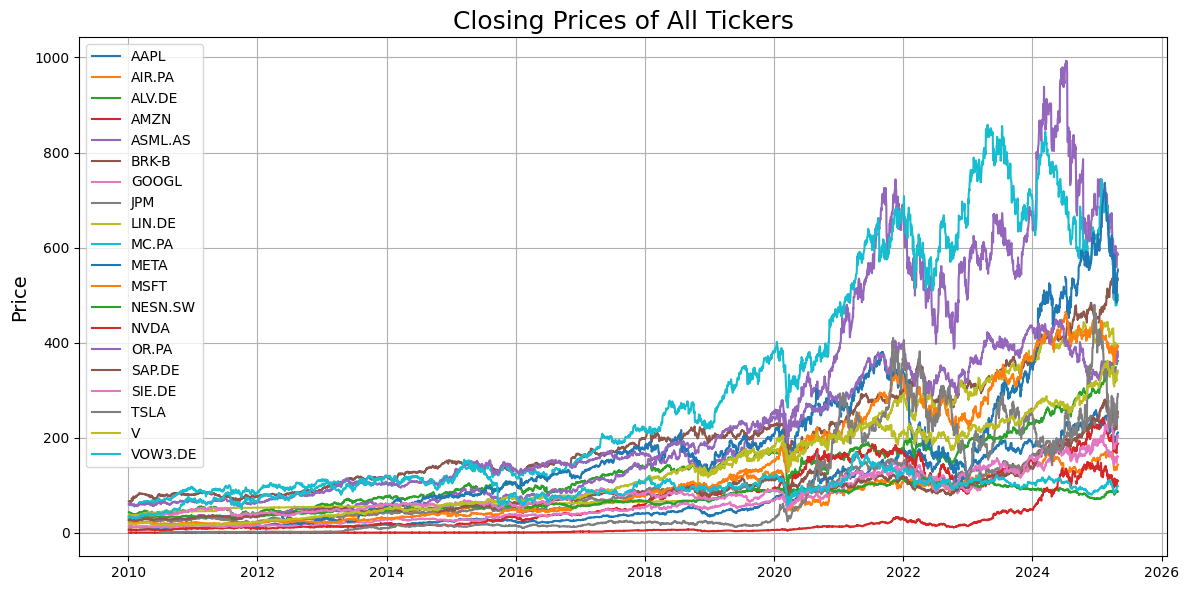

In [6]:
# 5) Quick plot of historical closes
plt.figure(figsize=(12,6))
for sym in close_data.columns:
    plt.plot(close_data[sym], label=sym)
plt.title('Closing Prices of All Tickers', fontsize=18)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# 6) Prepare train/test
log_price = log_close_data.copy()
log_train = log_price.loc[:train_end].dropna()
log_test  = log_price.loc[test_start:].dropna()


In [10]:
# 7) ARIMA grid-search setup
p_range = range(0, 6)
d = 1
q_range = range(0, 6)
bic_summary = []

for sym in tickers:
    # Safe pull of the log-price series
    try:
        series = log_data[('LogClose', sym)].dropna()
    except KeyError:
        print(f"⚠️ {sym} not found in log_data, skipping.")
        continue

    print(f"\nRunning ARIMA BIC grid search for {sym}...")
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(series, order=(p, d, q))
                fitted = model.fit()
                results.append({
                    'p': p, 'd': d, 'q': q,
                    'BIC': fitted.bic
                })
            except Exception:
                continue

    df = pd.DataFrame(results)
    if df.empty:
        print(f"  No ARIMA(p,d,q) could be fitted for {sym}.")
        continue

    best_bic = df.loc[df['BIC'].idxmin()]
    print(f"  → Best BIC:  ARIMA{(best_bic.p, best_bic.d, best_bic.q)}  (BIC={best_bic.BIC:.2f})")

    bic_summary.append({
        'Ticker': sym,
        'Best_BIC_Order': (best_bic.p, best_bic.d, best_bic.q),
        'Best_BIC': best_bic.BIC
    })

# 8) Show BIC summary
bic_summary_df = pd.DataFrame(bic_summary)
print("\n=== Summary of Best BIC Models ===")
print(bic_summary_df)



Running ARIMA BIC grid search for AAPL...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))  (BIC=-20059.16)

Running ARIMA BIC grid search for MSFT...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(1.0))  (BIC=-20846.86)

Running ARIMA BIC grid search for NVDA...
  → Best BIC:  ARIMA(np.float64(1.0), np.float64(1.0), np.float64(0.0))  (BIC=-16357.41)

Running ARIMA BIC grid search for AMZN...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))  (BIC=-18931.38)

Running ARIMA BIC grid search for GOOGL...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))  (BIC=-20302.32)

Running ARIMA BIC grid search for META...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))  (BIC=-14699.05)

Running ARIMA BIC grid search for TSLA...
  → Best BIC:  ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))  (BIC=-14119.71)

Running ARIMA BIC grid search for BRK-B...
  → Best BIC:  ARIMA(np.float64

In [12]:
bic_df = bic_summary_df.copy()

all_bic_forecasts = {}

for _, row in bic_df.iterrows():
    ticker = row['Ticker']
    order  = tuple(row['Best_BIC_Order'])

    print(f"\nRolling forecast for {ticker} using BIC‑optimal ARIMA{order}...")

    # Pull log‑price series from the MultiIndex
    try:
        series = log_data[('LogClose', ticker)].dropna()
    except KeyError:
        print(f"  ⚠️ {ticker} not found in log_data, skipping.")
        continue

    # Split into train/test
    log_train = series.loc[:train_end].copy()
    log_test  = series.loc[test_start:].copy()

    if log_train.empty or log_test.empty:
        print(f"  ⚠️ {ticker}: insufficient data, skipping.")
        continue

    history    = log_train.copy()
    predictions = []
    actuals     = []
    pred_index  = []

    # One‑step rolling forecast
    for current_time in tqdm(log_test.index, desc=f"Forecasting {ticker}"):
        try:
            model     = ARIMA(history, order=order, trend='t')
            fit       = model.fit()
            forecast  = fit.forecast(steps=1)
            pred_val  = float(forecast)

            predictions.append(pred_val)
            actuals.append(log_test.loc[current_time])
            pred_index.append(current_time)

            # Update history
            history.loc[current_time] = log_test.loc[current_time]
        except Exception as e:
            print(f"  Error at {current_time}: {e}")
            continue

    # Store results in a DataFrame
    all_bic_forecasts[ticker] = pd.DataFrame({
        'Predicted': predictions,
        'Actual':    actuals
    }, index=pred_index)

# Combine into a MultiIndex DataFrame
bic_combined_forecasts = pd.concat(
    all_bic_forecasts, names=['Ticker','Date']
)
bic_combined_forecasts.index.set_names(['Ticker','Date'], inplace=True)

print("\n✅ Rolling forecasts with BIC‑optimal ARIMA models completed.")



Rolling forecast for AAPL using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting AAPL: 100%|██████████| 80/80 [00:48<00:00,  1.65it/s]



Rolling forecast for MSFT using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(1.0))...


Forecasting MSFT: 100%|██████████| 80/80 [01:16<00:00,  1.05it/s]



Rolling forecast for NVDA using BIC‑optimal ARIMA(np.float64(1.0), np.float64(1.0), np.float64(0.0))...


Forecasting NVDA: 100%|██████████| 80/80 [00:15<00:00,  5.07it/s]



Rolling forecast for AMZN using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting AMZN: 100%|██████████| 80/80 [00:46<00:00,  1.73it/s]



Rolling forecast for GOOGL using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting GOOGL: 100%|██████████| 80/80 [00:47<00:00,  1.67it/s]



Rolling forecast for META using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting META: 100%|██████████| 80/80 [00:39<00:00,  2.04it/s]



Rolling forecast for TSLA using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting TSLA: 100%|██████████| 80/80 [00:38<00:00,  2.06it/s]



Rolling forecast for BRK-B using BIC‑optimal ARIMA(np.float64(1.0), np.float64(1.0), np.float64(0.0))...


Forecasting BRK-B: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]



Rolling forecast for JPM using BIC‑optimal ARIMA(np.float64(2.0), np.float64(1.0), np.float64(3.0))...


Forecasting JPM: 100%|██████████| 80/80 [06:11<00:00,  4.65s/it]



Rolling forecast for V using BIC‑optimal ARIMA(np.float64(1.0), np.float64(1.0), np.float64(0.0))...


Forecasting V: 100%|██████████| 80/80 [00:12<00:00,  6.64it/s]



Rolling forecast for SAP.DE using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting SAP.DE: 100%|██████████| 82/82 [00:38<00:00,  2.11it/s]



Rolling forecast for SIE.DE using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting SIE.DE: 100%|██████████| 82/82 [00:51<00:00,  1.59it/s]



Rolling forecast for ALV.DE using BIC‑optimal ARIMA(np.float64(1.0), np.float64(1.0), np.float64(0.0))...


Forecasting ALV.DE: 100%|██████████| 82/82 [00:26<00:00,  3.11it/s]



Rolling forecast for VOW3.DE using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(1.0))...


Forecasting VOW3.DE: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]



Rolling forecast for LIN.DE using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(1.0))...


Forecasting LIN.DE: 100%|██████████| 82/82 [01:14<00:00,  1.10it/s]



Rolling forecast for MC.PA using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting MC.PA: 100%|██████████| 82/82 [00:54<00:00,  1.52it/s]



Rolling forecast for OR.PA using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(1.0))...


Forecasting OR.PA: 100%|██████████| 82/82 [00:51<00:00,  1.60it/s]



Rolling forecast for AIR.PA using BIC‑optimal ARIMA(np.float64(2.0), np.float64(1.0), np.float64(2.0))...


Forecasting AIR.PA: 100%|██████████| 82/82 [04:13<00:00,  3.09s/it]



Rolling forecast for ASML.AS using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting ASML.AS: 100%|██████████| 82/82 [00:47<00:00,  1.74it/s]



Rolling forecast for NESN.SW using BIC‑optimal ARIMA(np.float64(0.0), np.float64(1.0), np.float64(0.0))...


Forecasting NESN.SW: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


✅ Rolling forecasts with BIC‑optimal ARIMA models completed.


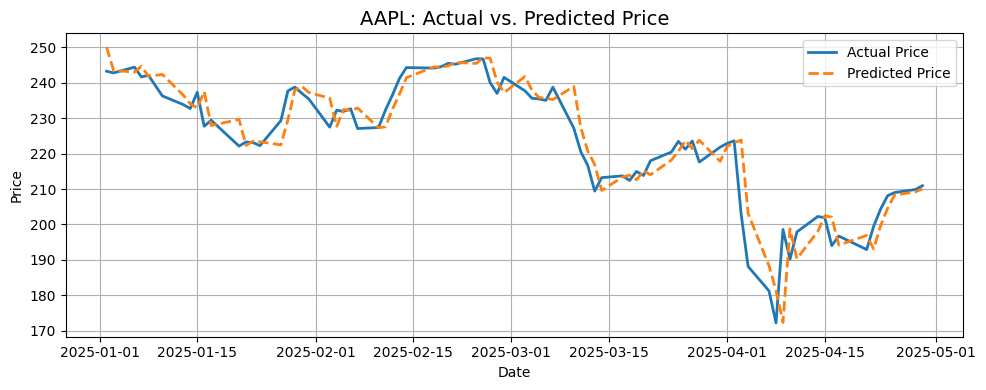

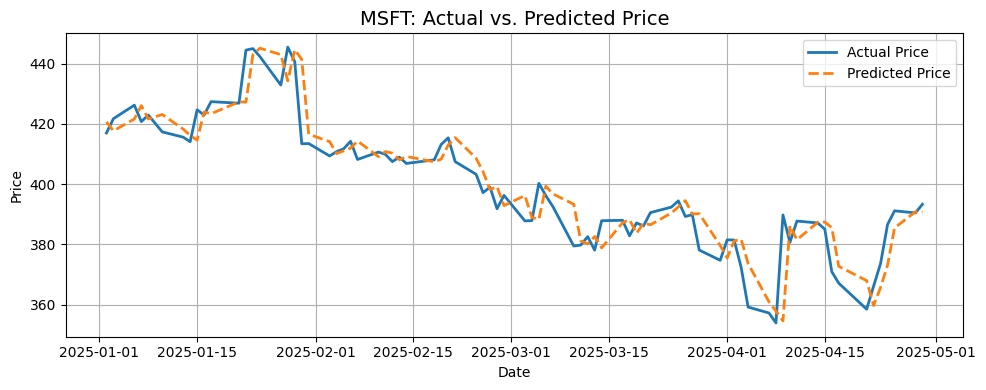

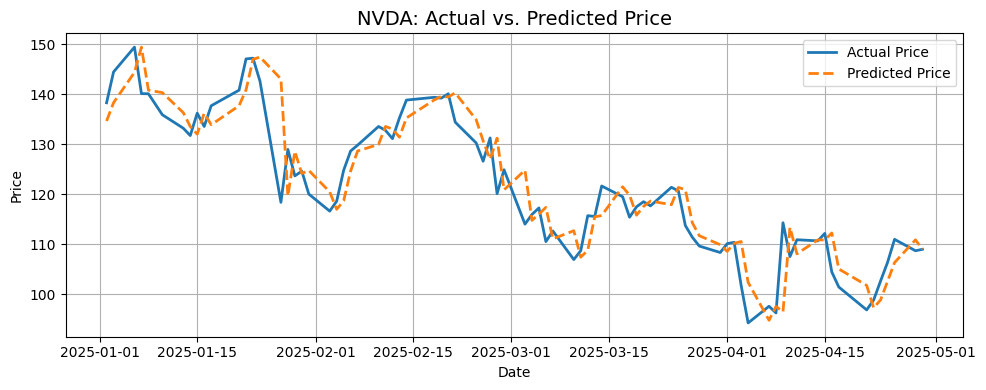

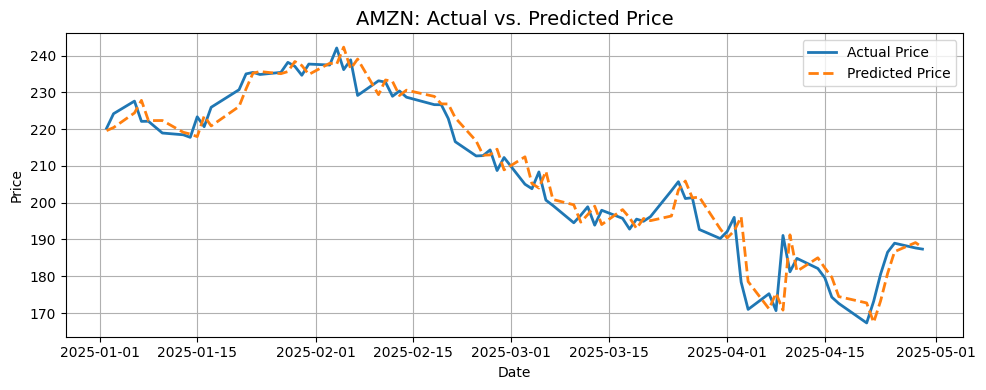

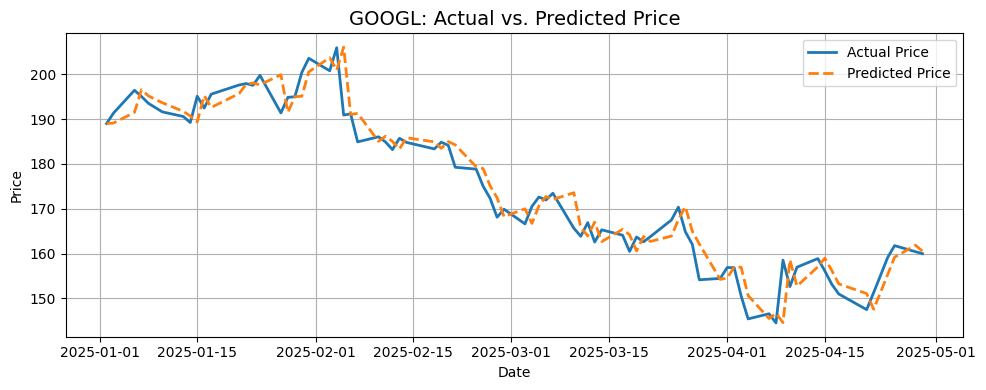

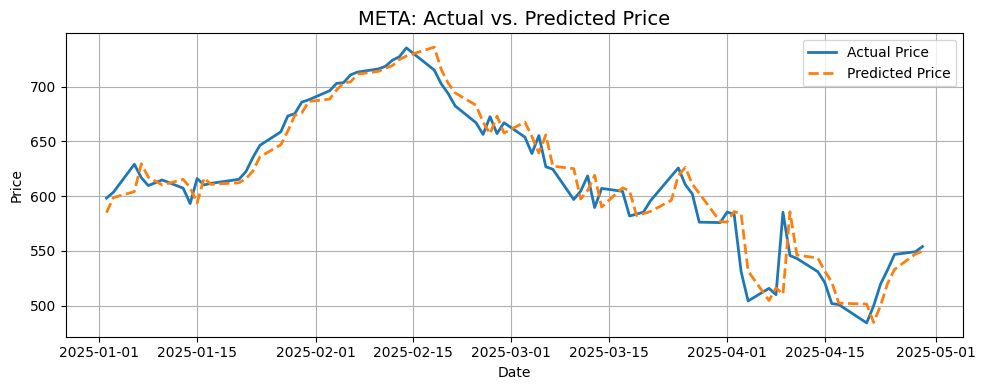

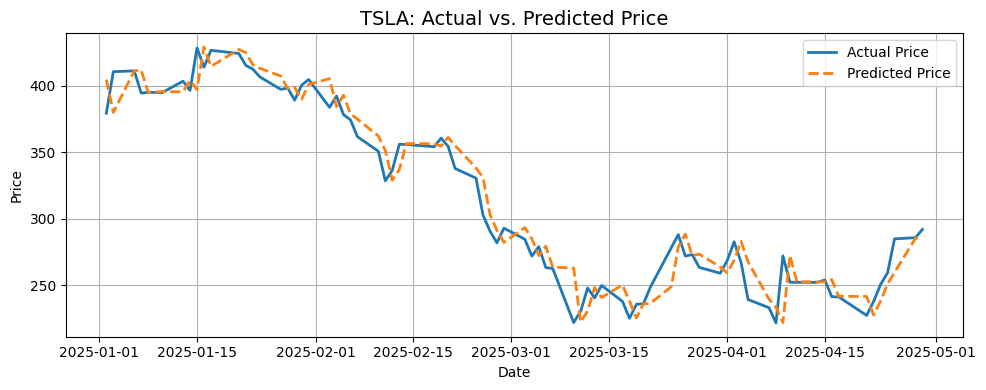

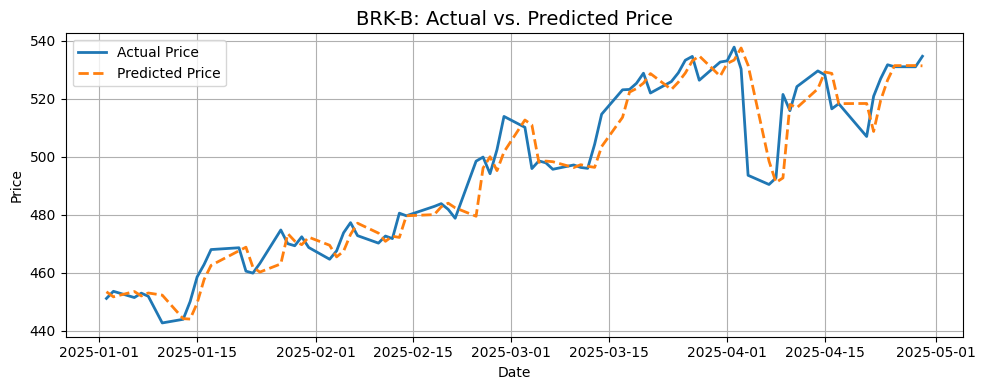

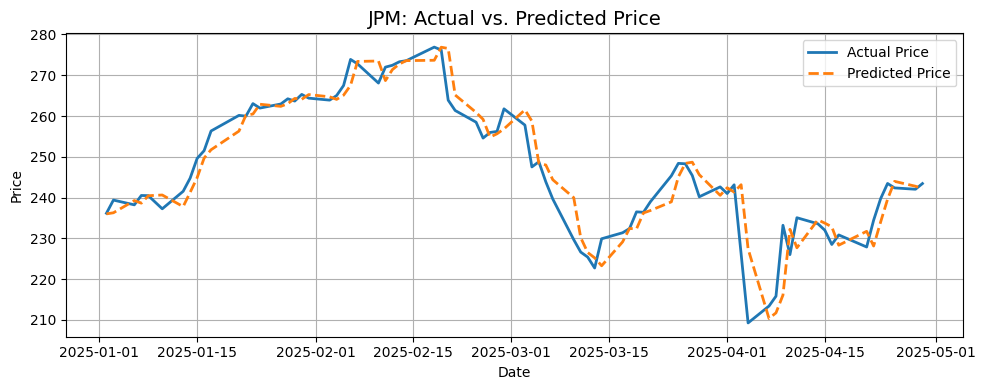

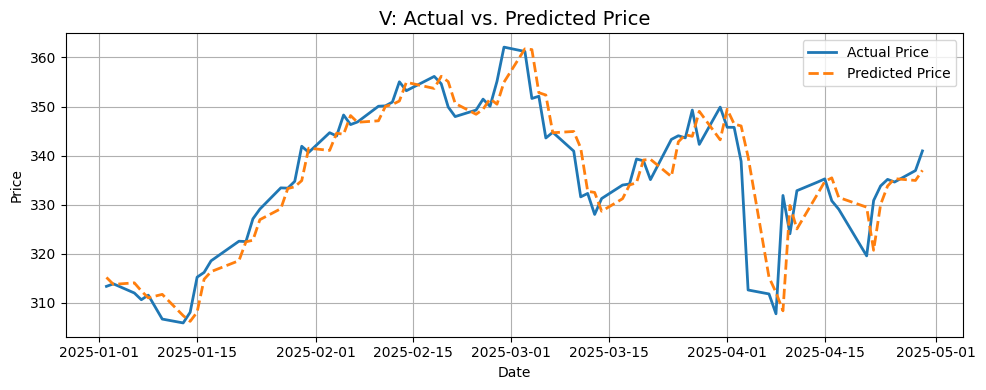

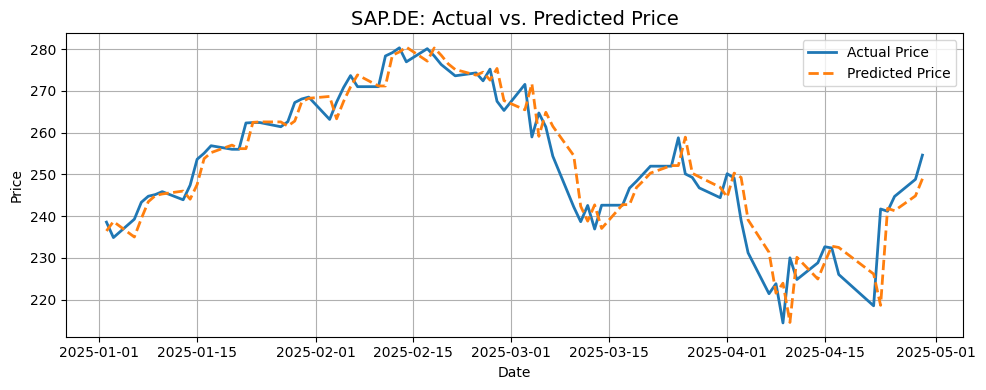

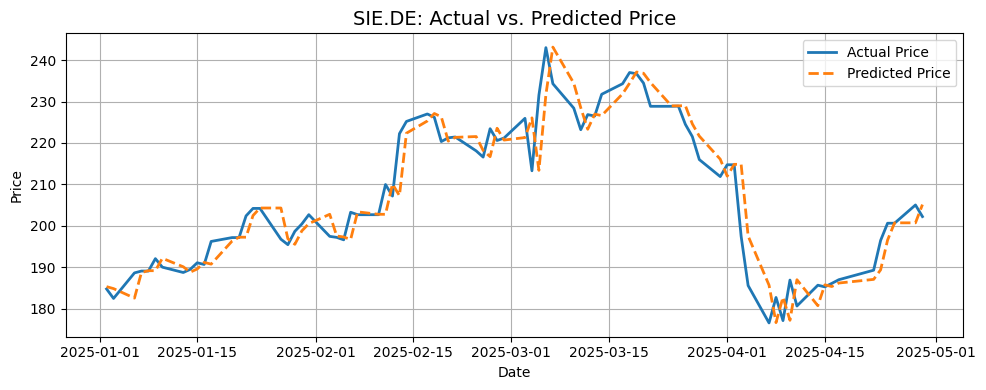

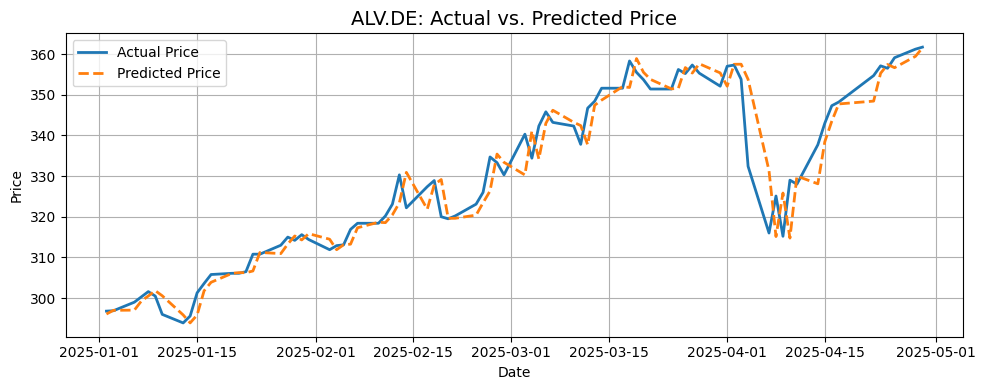

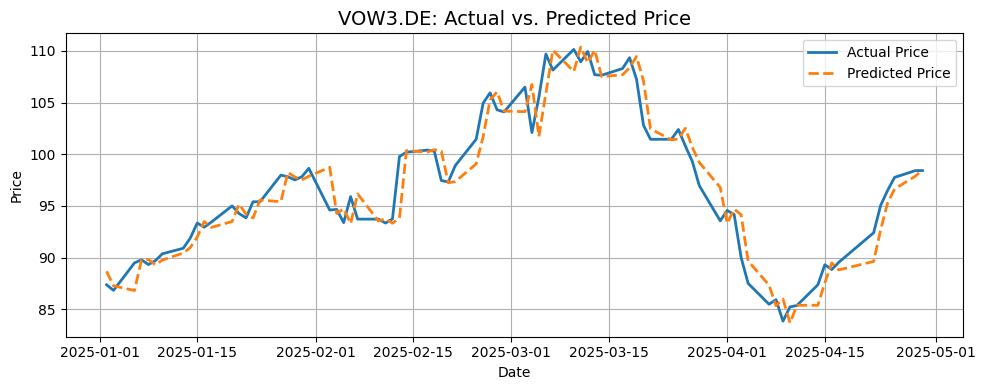

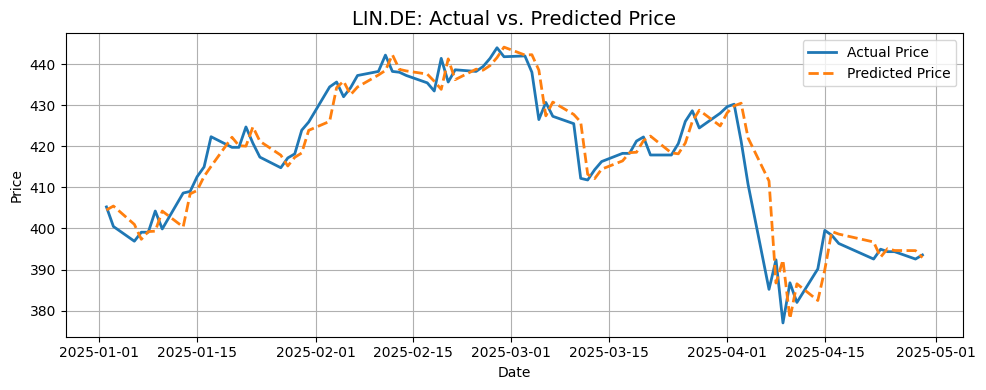

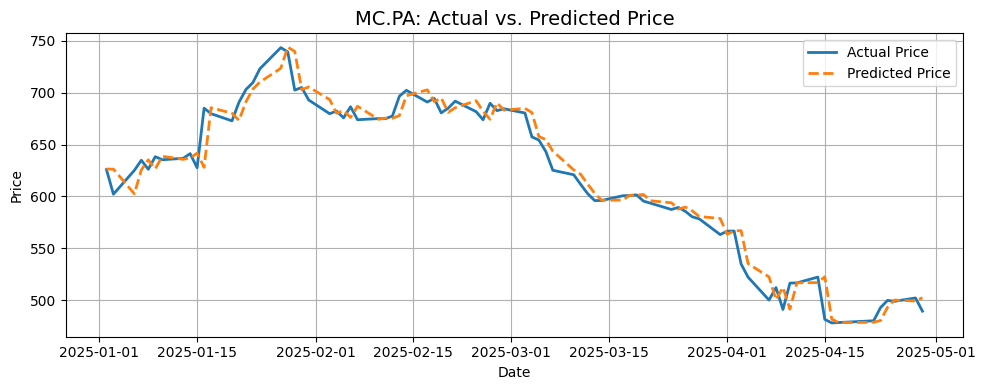

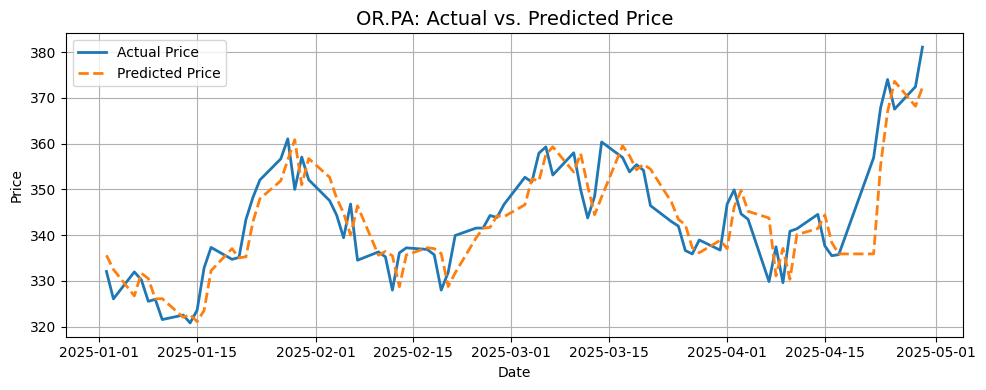

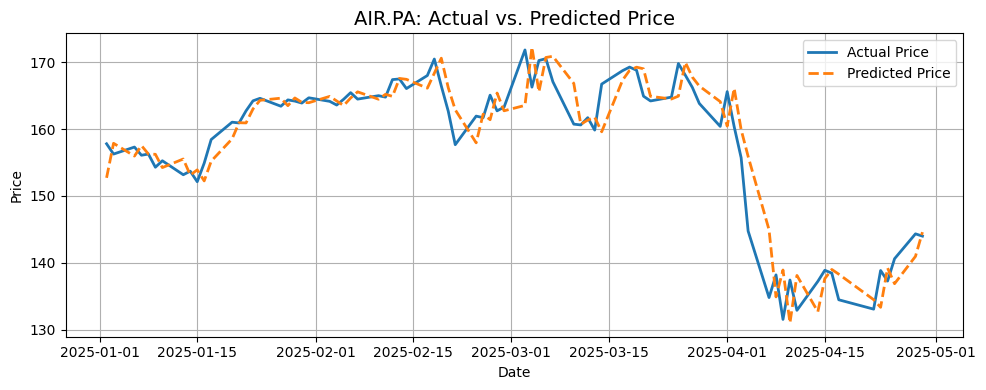

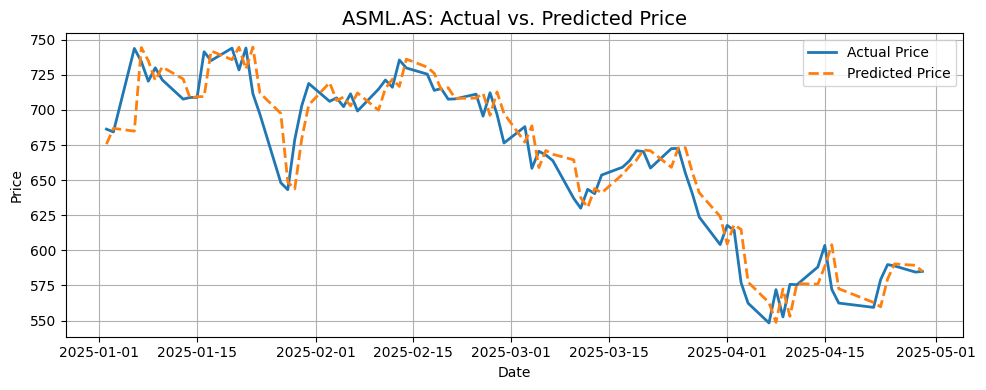

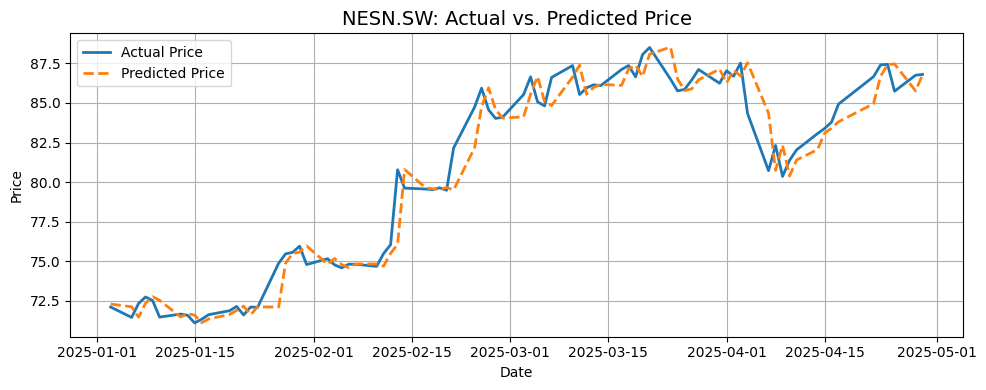

In [15]:
for ticker in all_bic_forecasts:
    df = all_bic_forecasts[ticker]

    actual_price    = np.exp(df['Actual'])
    predicted_price = np.exp(df['Predicted'])

    plt.figure(figsize=(10, 4))
    plt.plot(df.index, actual_price,    label='Actual Price',    linewidth=2)
    plt.plot(df.index, predicted_price, label='Predicted Price', linewidth=2, linestyle='--')
    plt.title(f'{ticker}: Actual vs. Predicted Price', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
mae_results = {}

for ticker, df in all_bic_forecasts.items():
    # Convert back to actual prices
    actual_prices    = np.exp(df['Actual'])
    predicted_prices = np.exp(df['Predicted'])

    # Compute MAE
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mae_results[ticker] = mae

# Turn it into a nice DataFrame
mae_df = pd.DataFrame.from_dict(mae_results, orient='index', columns=['MAE'])
mae_df.index.name = 'Ticker'
print(mae_df)


               MAE
Ticker            
AAPL      4.091392
MSFT      5.508590
NVDA      4.018604
AMZN      3.804370
GOOGL     3.076819
META     12.541686
TSLA     11.530044
BRK-B     5.296579
JPM       3.527638
V         3.797573
SAP.DE    3.971100
SIE.DE    3.878375
ALV.DE    3.551259
VOW3.DE   1.455966
LIN.DE    3.831369
MC.PA     9.869994
OR.PA     4.862815
AIR.PA    2.631216
ASML.AS  13.148421
NESN.SW   0.848171


In [19]:
rmse_results = {}

for ticker, df in all_bic_forecasts.items():
    # Convert log‑prices back to levels
    actual_prices    = np.exp(df['Actual'])
    predicted_prices = np.exp(df['Predicted'])

    # Compute RMSE as sqrt of MSE
    mse  = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)

    rmse_results[ticker] = rmse

# Create a DataFrame of results
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.index.name = 'Ticker'

print(rmse_df)



              RMSE
Ticker            
AAPL      5.996919
MSFT      7.950594
NVDA      5.543244
AMZN      5.093458
GOOGL     4.055473
META     17.143786
TSLA     14.922781
BRK-B     7.986166
JPM       5.121703
V         5.794724
SAP.DE    5.516563
SIE.DE    5.506522
ALV.DE    5.233282
VOW3.DE   1.924458
LIN.DE    5.551702
MC.PA    14.028798
OR.PA     6.108709
AIR.PA    3.548107
ASML.AS  17.075604
NESN.SW   1.222098


In [26]:
# 1) Forecast horizon
horizon = 5

# 2) Prepare the business‑day index for the next 5 trading days
last_dates = [log_data[('LogClose', t)].dropna().index[-1] for t in tickers]
last_date  = max(last_dates)
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1),
                              periods=horizon)

# 3) DataFrame to hold price forecasts for all tickers
future_price_df = pd.DataFrame(index=future_index, columns=tickers)

# 4) Loop through each ticker, fit ARIMA on the full log‑price series, forecast, and exponentiate
for ticker in tickers:

    order = tuple(bic_summary_df.loc[bic_summary_df['Ticker'] == ticker, 'Best_BIC_Order'].iloc[0])

    series = log_data[('LogClose', ticker)].dropna()
    if series.empty:
        print(f"⚠️ {ticker} has no data, skipping.")
        continue

    # Fit and forecast h‑steps ahead in log‑space
    model = ARIMA(series, order=order, trend='t')
    fit   = model.fit()
    fc_log = fit.forecast(steps=horizon)

    # Convert log‑forecasts back to price levels
    fc_price = np.exp(fc_log)
    fc_price.index = future_index

    # Store in the combined DataFrame
    future_price_df[ticker] = fc_price

# 5) Display the 5‑day ahead price forecasts for all stocks
print(future_price_df)


                  AAPL        MSFT        NVDA        AMZN       GOOGL  \
2025-04-30  211.123504  393.342682  109.161711  187.551176  160.062249   
2025-05-01  211.313784  393.630904  109.319349  187.712491  160.158201   
2025-05-02  211.504235  393.919337  109.476744  187.873945  160.254210   
2025-05-05  211.694859  394.207981  109.634393  188.035537  160.350277   
2025-05-06  211.885654  394.496837  109.792267  188.197269  160.446402   

                  META        TSLA       BRK-B         JPM           V  \
2025-04-30  554.467265  292.436729  534.429791  243.303214  340.848485   
2025-05-01  554.921168  292.844026  534.774026  243.627325  341.134351   
2025-05-02  555.375442  293.251890  535.056378  243.713702  341.383393   
2025-05-05  555.830089  293.660322  535.346837  243.868604  341.636126   
2025-05-06  556.285107  294.069323  535.636434  243.990105  341.888714   

                SAP.DE      SIE.DE      ALV.DE    VOW3.DE      LIN.DE  \
2025-04-30  254.747794  202.343625  3